# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.1.0
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2023.7.22
cffi                      1.16.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
executing                 2.0.1
fastjsonschema            2.19.1
flatbuffers               24.3.25
fonttools                 4.51.0
fqdn                      1.5.1
gast                      0.5.4
google-pasta  

In [14]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
    # tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# tf.config.list_physical_devices('GPU')

# 2. Remove dodgy images

In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
# os.listdir(data_dir) # directories/ ckass labels

In [9]:
# os.listdir(os.path.join(data_dir, 'sad')) # images

In [10]:
# img = cv2.imread(os.path.join('data', 'happy', '35438_hd.jpg'))
# img.shape

In [11]:
# plt.imshow(img)

In [12]:
# opencv reads in bgr, matplotlib expects it to be rgb
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

In [13]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data\happy\.ipynb_checkpoints


# 3. Load Data

In [15]:
# tf.keras.utils.image_dataset_from_directory??
# Assign batch size, shuffle, image size, etc. everything

In [16]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 251 files belonging to 2 classes.


In [17]:
data_iterator = data.as_numpy_iterator()

In [18]:
batch = data_iterator.next()

In [57]:
# batch[0] # .shape

In [58]:
# batch[1]

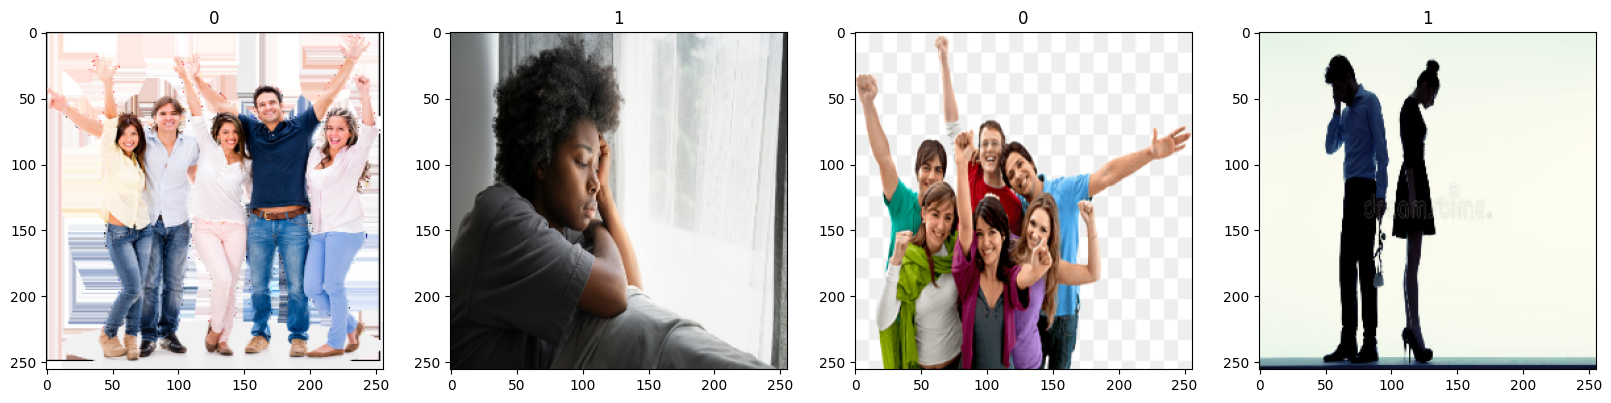

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# Sad = 1
# Happy = 0

# 4. Scale Data

In [20]:
data = data.map(lambda x,y: (x/255, y))

# 5. Split Data

In [29]:
len(data) # no. of batches

8

In [31]:
train_size = len(data)*.7
val_size = len(data)*.2
test_size = len(data)*.1
print(train_size)
print(val_size)
print(test_size)

5.6
1.6
0.8


In [33]:
train = data.take(5)

In [36]:
remaining = data.skip(5)
len(remaining)

3

In [39]:
val = remaining.take(2)
test = remaining.skip(2)
len(test)

1

In [40]:
print(len(train)+len(val)+len(test) == len(data))

True


# 6. Build Deep Learning Model

In [42]:
from tensorflow.keras import models, layers

In [57]:
model = models.Sequential()

In [58]:
# Conv2D(no. of filters, filter_size, stride, activation, input_shape(for first layer))
model.add(layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3,3), 1, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [61]:
model.summary() # biases included

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# 7. Train

In [62]:
logdir='logs'

In [63]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [64]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 484ms/step - accuracy: 0.5736 - loss: 1.0588 - val_accuracy: 0.7500 - val_loss: 0.6318
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.6444 - loss: 0.6492 - val_accuracy: 0.6562 - val_loss: 0.5985
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.6746 - loss: 0.5873 - val_accuracy: 0.7812 - val_loss: 0.5334
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.8399 - loss: 0.4712 - val_accuracy: 0.9219 - val_loss: 0.3628
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.8317 - loss: 0.4349 - val_accuracy: 0.9531 - val_loss: 0.2917
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.8595 - loss: 0.3261 - val_accuracy: 0.9531 - val_loss: 0.2050
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - accuracy: 0.9016 - loss: 0.2583 - val_accuracy: 0.9375 - val_loss: 0.1623
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.9503 - loss: 0.1710 - val_accuracy: 0.9844 - val_loss:

# 8. Plot Performance

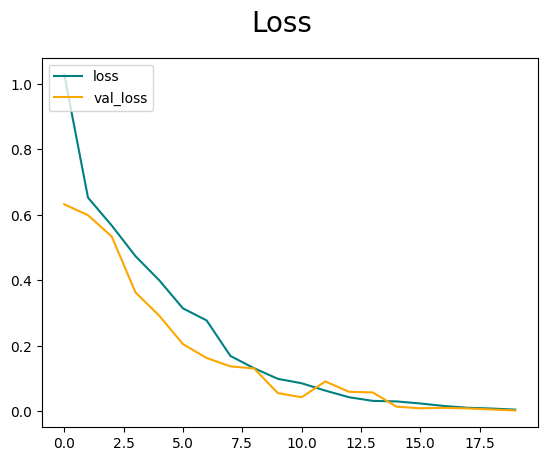

In [65]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

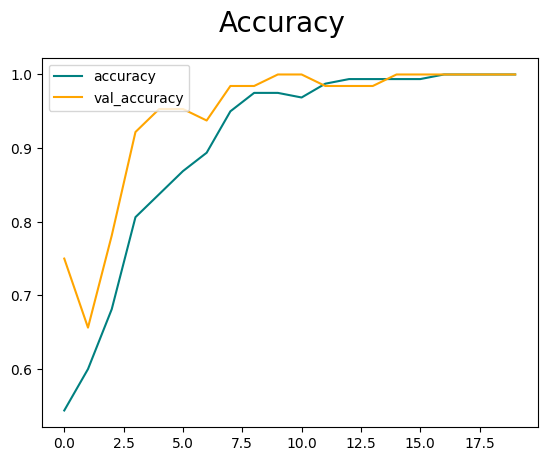

In [66]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [67]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [68]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [69]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


In [71]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1.0 1.0 1.0


# 10. Test

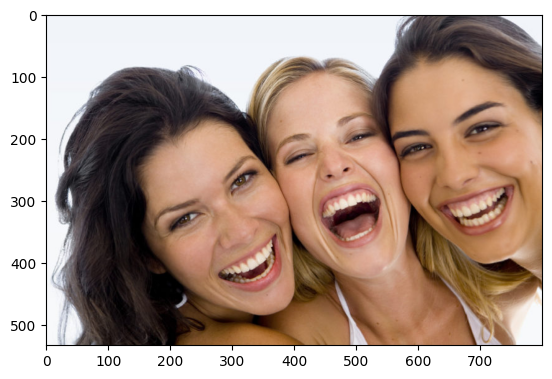

In [96]:
img = cv2.imread('happytest2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

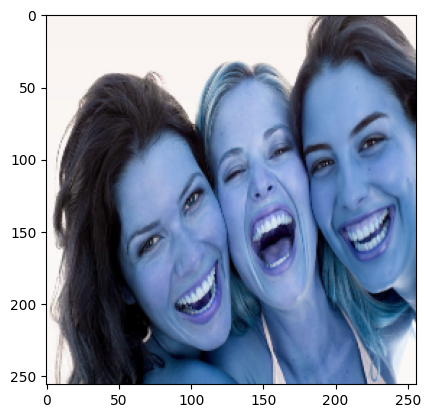

In [97]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [98]:
yhat = model.predict(np.expand_dims(resize/255, 0)) # our nn expects a batch of images, not single image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [99]:
yhat

array([[0.07752556]], dtype=float32)

In [100]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [101]:
from tensorflow.keras.models import load_model

In [103]:
model.save(os.path.join('models','imageclassifier.keras'))

In [106]:
new_model = load_model('models/imageclassifier.keras')

C:\Users\Chirag Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [107]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


array([[0.07752556]], dtype=float32)

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")